# **Programming Assignment 2 - Object Detection + Semantic Segmentation**

#### **Professor**: Dário Oliveira  
#### **Monitora**: Lívia Meinhardt


O objetivo deste trabalho é construir um pipeline de visão computacional que primeiro **detecta** objetos em uma imagem e, em seguida, realiza a **segmentação semântica** em cada objeto detectado. Ou seja, uma segmentação de instância em duas etapas. 

Vocês irão construir e conectar dois modelos distintos:
1.  Um **detector de objetos** (YOLO) para encontrar a localização dos objetos.
2.  Um **segmentador semântico** (U-Net ou outro) para classificar os pixels dentro de cada objeto localizado.

### **Instruções:**

1. **Criação de um Dataset**:  
Vocês usarão o dataset **[PASCAL VOC 2012](https://www.kaggle.com/datasets/gopalbhattrai/pascal-voc-2012-dataset)**. Este conjunto de dados é ideal porque fornece anotações tanto para **caixas delimitadoras** (*bounding boxes*), para a tarefa de detecção, quanto para **máscaras de segmentação** a nível de pixel. 


2. **Implementação e Treinamento da YOLO:**
Sua primeira tarefa é fazer a implementação da YOLOv3, vista em aula. Treine um modelo que recebe uma imagem como entrada e retorna uma lista de predições, onde cada predição contém `(caixa_delimitadora, classe, score_de_confiança)`. Meça o desempenho do seu detector usando a métrica **Mean Average Precision (mAP)**.


3. **Treinar o Segmentador Semântico:**
Sua segunda tarefa é treinar um modelo **U-Net** ou outro de sua preferência para realizar a segmentação. O ponto crucial é que vocês não irão treinar a U-Net com imagens inteiras. Em vez disso, vocês a treinarão com **recortes de imagem (*patches*)** gerados a partir das caixas delimitadoras de referência (*ground-truth*) do dataset. Meça o desempenho do seu segmentador usando a métrica **Average Precision (AP).**

4. **Construir o Pipeline de Inferência:**
    Agora, conecte seus dois modelos treinados. Esta parte envolve escrever um script que executa a tarefa completa de ponta a ponta.

    1.  **Detectar**: Use uma nova imagem de teste e passe-a pelo seu modelo **YOLOv3** treinado para obter uma lista de caixas delimitadoras preditas.
    2.  **Recortar**: Para cada predição de alta confiança do YOLO, **recorte o *patch* da imagem** definido pela caixa delimitadora.
    3.  **Segmentar**: Passe cada *patch* recortado pelo seu modelo **U-Net** treinado para obter uma máscara de segmentação para aquele objeto específico.
    4.  **Combinar**: Crie uma imagem em branco (preta) do mesmo tamanho da imagem original. "Costure" cada máscara gerada de volta nesta imagem em branco, na sua localização original da caixa delimitadora.
    5.  **Visualizar**: Sobreponha a máscara final combinada na imagem original para criar uma visualização final mostrando todos os objetos detectados e segmentados.


5. **Compare com um método *end-to-end:***
Por fim, faça *fine-tuning* do [**Mask R-CNN**](https://docs.pytorch.org/vision/main/models/mask_rcnn.html), um um modelo de segmentação de instância de ponta a ponta (*end-to-end*). Compare o desempenho com o seu pipeline de dois estágios e discuta as diferenças. 


### **Entrega:**

Você deve enviar:

1.  Um **Jupyter Notebook** contendo todo o seu código.
2.  Os **pesos treinados** tanto do seu detector YOLOv3 quanto do seu segmentador U-Net.
3.  Um **relatório ou apresentação** que discuta os desafios e resultados dos seus experimentos. 

## Preparando o dataset pra detecção

In [ ]:
import kagglehub
gopalbhattrai_pascal_voc_2012_dataset_path = kagglehub.dataset_download('gopalbhattrai/pascal-voc-2012-dataset')

print('Data source import complete.')

In [ ]:
gopalbhattrai_pascal_voc_2012_dataset_path

In [1]:
import torch
from torch import nn
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

from torchvision.transforms import ToTensor, Lambda
from torchvision.io import decode_image
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
from torchvision.models.segmentation.deeplabv3 import DeepLabHead, FCNHead

#from torchtune.datasets import ConcatDataset

from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

from tqdm import tqdm

import os
from glob import glob

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"using device '{device}'")

using device 'cuda'


In [2]:
import os
import random
from PIL import Image
import shutil
from ultralytics import YOLO

# Define dataset root
original_dataset_path = 'data'
yolo_dataset_path = 'yolo_dataset'

In [6]:
yolo_dirs = [
    os.path.join(yolo_dataset_path, 'images', 'train'),
    os.path.join(yolo_dataset_path, 'images', 'val'),
    os.path.join(yolo_dataset_path, 'labels', 'train'),
    os.path.join(yolo_dataset_path, 'labels', 'val')
]

for yolo_dir in yolo_dirs:
    os.makedirs(yolo_dir, exist_ok=True)

jpeg_images_dir = os.path.join(original_dataset_path, 'VOC2012_train_val', 'JPEGImages')
annotations_dir = os.path.join(original_dataset_path, 'VOC2012_train_val', 'Annotations')
if not os.path.exists(jpeg_images_dir) or not os.path.exists(annotations_dir):
    raise FileNotFoundError(f"The directory {jpeg_images_dir} or {annotations_dir} does not exist. Please verify the dataset path.")
image_filenames = os.listdir(jpeg_images_dir)
image_ids = [os.path.splitext(filename)[0] for filename in image_filenames if filename.endswith('.jpg')]

random.seed(42)
random.shuffle(image_ids)
split_index = int(0.8 * len(image_ids)) #Spliting the dataset 80% for training, 20% for validation
train_ids = image_ids[:split_index] #taking the first 80% pictures
val_ids = image_ids[split_index:]

FileNotFoundError: The directory /home/pedro/Modelos/Faculdade/DL/Assignment 2/data/VOC2012_train_val/JPEGImages or /home/pedro/Modelos/Faculdade/DL/Assignment 2/data/VOC2012_train_val/Annotations does not exist. Please verify the dataset path.

In [ ]:
import xml.etree.ElementTree as ET 
#this fucntion converts PASCAL_VOC annotations to YOLO format
def create_yolo_annotation(xml_file_path, yolo_label_path, label_dict):
    tree = ET.parse(xml_file_path)
    root = tree.getroot()
    annotations = [] #list that will store the converted YOLO annotations.

    img_width = int(root.find('size/width').text)
    img_height = int(root.find('size/height').text)

    for obj in root.findall('object'):
        label = obj.find('name').text
        if label not in label_dict:
            continue
        label_idx = label_dict[label]
        bndbox = obj.find('bndbox')
        xmin = float(bndbox.find('xmin').text)
        ymin = float(bndbox.find('ymin').text)
        xmax = float(bndbox.find('xmax').text)
        ymax = float(bndbox.find('ymax').text)

        # this is YOLOv8 annotation format: label x_center y_center width height (normalized)
        x_center = ((xmin + xmax) / 2) / img_width
        y_center = ((ymin + ymax) / 2) / img_height
        width = (xmax - xmin) / img_width
        height = (ymax - ymin) / img_height

        annotations.append(f"{label_idx} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

    #annotations to the label file
    with open(yolo_label_path, 'w') as f:
        f.write("\n".join(annotations))

In [ ]:
label_dict = {
    'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4,
    'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9,
    'diningtable': 10, 'dog': 11, 'horse': 12, 'motorbike': 13, 'person': 14,
    'pottedplant': 15, 'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19
}

for image_set, ids in [('train', train_ids), ('val', val_ids)]:
    for img_id in ids:
        img_src_path = os.path.join(jpeg_images_dir, f'{img_id}.jpg')
        label_dst_path = os.path.join(yolo_dataset_path, 'labels', image_set, f'{img_id}.txt')

        # Create the YOLO annotation file
        xml_file_path = os.path.join(annotations_dir, f'{img_id}.xml')
        if not os.path.exists(xml_file_path):
            print(f"Warning: Annotation {xml_file_path} not found, skipping.")
            continue
        create_yolo_annotation(xml_file_path, label_dst_path, label_dict)

        # Copy the image to the new YOLO dataset structure
        img_dst_path = os.path.join(yolo_dataset_path, 'images', image_set, f'{img_id}.jpg')
        shutil.copy(img_src_path, img_dst_path)

### Testando na YOLOv8

In [ ]:
yaml_content = f"""
train: images/train
val: images/val

nc: {len(label_dict)}
names: {list(label_dict.keys())}
"""

with open(os.path.join(yolo_dataset_path, 'data.yaml'), 'w') as f:
    f.write(yaml_content)

In [ ]:
model = YOLO('yolov8n.pt')  # Use the YOLOv8 nano model

# Train the model
model.train(
    data=os.path.join(yolo_dataset_path, 'data.yaml'),  # Path to dataset config file
    epochs=2,  # Number of epochs
    imgsz=640,  # Image size
    batch=16,  # Batch size
    name='yolov8_test'  # Experiment name
)

In [ ]:
results = model.predict(source=os.path.join(yolo_dataset_path, 'images/val/'), save=True)  # Run inference on validation set

# Display predictions
for result in results:
    result.show()
    break

In [ ]:
max_conf = 0
best_result = None

for result in results:    
        if (result.boxes.conf.mean().item() > max_conf) and (result.boxes.conf.mean().item() < 0.98) and (result.boxes.conf.shape[0] > 2):
            max_conf = result.boxes.conf.mean().item()
            best_result = result

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

img = best_result.orig_img
boxes = best_result.boxes.xyxy.cpu().numpy()  # xyxy format
classe = best_result.boxes.cls
confianca = best_result.boxes.conf

fig, ax = plt.subplots(1)
ax.imshow(img)

for i, box in enumerate(boxes):
    x1, y1, x2, y2 = box[:4]
    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    # Add class and confidence
    class_idx = int(classe[i])
    class_name = best_result.names[class_idx] if hasattr(best_result, 'names') else str(class_idx)
    conf = float(confianca[i])
    ax.text(x1, y1 - 5, f'{class_name}: {conf:.2f}', color='red', fontsize=10, backgroundcolor='white')

plt.show()

# Dataloader

In [ ]:
class YoloDataset(Dataset):

    def __init__(self, type_, dataset_path = ["yolo_dataset"], device = "cpu"):
        self.base_path_data = os.path.join(*dataset_path, "images", f"{type_}")
        self.base_path_labels = os.path.join(*dataset_path, "labels", f"{type_}")

        self.images = glob(os.path.join(self.base_path_data, "*.jpg"))

        self.device = device

        self.classes = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]
        self.n_classes = len(self.classes)

    def __len__(self):
        return len(self.images)
    
    #Feito na inicialização da classe para pegar as prioris de caixas
    def clusterize_anchors(self, n_anchors):
        self.n_anchors = n_anchors

        labels = glob(os.path.join(self.base_path_labels, "*.txt"))

        annotations = list()
        centers = list()

        counter = 0
        for txt_path in labels:
            with open(txt_path, "r") as f:
                for line in f:
                    annotation = [float(x) for x in line.split()]
                    annotations.append(annotation)

        for annotation in annotations:
            centers.append([annotation[3], annotation[4]])
        
        kmeans = KMeans(self.n_anchors)
        kmeans.fit(centers)

        self.anchors = torch.tensor(kmeans.cluster_centers_)

    def set_anchors(self, anchors):
        self.anchors = anchors
        self.n_anchors = len(anchors)

    def get_anchors(self):
        return self.anchors

    def letterbox_data(self, image, boxes, new_dim):
        if image.shape[2] > image.shape[1]: #W > H
            scale_factor = new_dim/image.shape[2]
            new_H = int(scale_factor * image.shape[1])
            new_dims = (new_H, new_dim)

            resize = T.Resize(new_dims)
            padding = T.Pad([0, (new_dim - new_H)//2], fill = 117)

            box_scale = new_dims[0]/new_dim
            for box in boxes:
                box[2] = ((box[2] - 0.5) * box_scale) + 0.5
                box[4] *= box_scale


        elif image.shape[2] < image.shape[1]: #W < H
            scale_factor = new_dim/image.shape[1]
            new_W = int(scale_factor * image.shape[2])
            new_dims = (new_dim, new_W)

            resize = T.Resize(new_dims)
            padding = T.Pad([(new_dim - new_W)//2, 0], fill = 117)
            box_scale = new_dims[1]/new_dim
            for box in boxes:
                box[1] = ((box[1] - 0.5) * box_scale) + 0.5
                box[3] *= box_scale

        else: #W = H
            resize = T.Resize((new_dim, new_dim))
            padding = lambda x: x
            mode = "E"
        
        return padding(resize(image)), boxes

    def iou_wh(self, box_1, box_2):
        intersection = torch.min(box_1[0], box_2[:, 0]) * torch.min(box_1[1], box_2[:, 1])
        union = (box_1[0] * box_1[1]) + (box_2[:, 0] * box_2[:, 1]) - intersection
        return intersection / union

    # TODO: otimizar e modularizar
    def __getitem__(self, idx):
        dim = 416
        #Pega o path da imagem e da label e carrega
        img_path = self.images[idx]
        name = img_path.split("/")[-1].split(".")[0]
        label_path = os.path.join(self.base_path_labels, f"{name}.txt")

        #Carrega as boxes e muda de acordo com o letterbox (talvez separar em outra função? n sei)
        boxes = []
        with open(label_path, "r") as f:
            for box in f:
                boxes.append([float(x) for x in box.split()])
        
        #Dá letterbox na imagem e nas boxes
        image = decode_image(img_path).to(torch.float).to(self.device)
        letterbox_image, boxes = self.letterbox_data(image, boxes, dim)

        #Agora com a imagem e boxes no tamanho certo, cria as boxes no formato do modelo
        strides = [32, 16, 8] #Pro modelo vai ser 8 16 32 mas deixei 32 pq não vi as outras saidas do modelo...
        matrixes = [] #Vai ter as saídas pra cada stride
        for stride in strides:
            if dim % stride != 0:
                raise ValueError(f"Dimensão {dim} incompatível com o stride {stride}")
            n_cells = dim//stride
            cell_relative_size = 1/n_cells

            output_matrix = torch.zeros((self.n_anchors, n_cells, n_cells, 5 + self.n_classes))

            for box in boxes:
                cell_x, cell_y = int(box[1]/cell_relative_size), int(box[2]/cell_relative_size) #H depois W

                dx = box[1] * n_cells - cell_x
                dy = box[2] * n_cells - cell_y

                IoUs = self.iou_wh(torch.tensor(box[3:5]), self.anchors)
                assigned_anchor_index = IoUs.argmax()
                if output_matrix[assigned_anchor_index, cell_y, cell_x, 0] == 1:
                    raise Exception("Duas bounding boxes anotadas ficaram associadas à mesma célula e a mesma anchor")
                #Meu amigo gem tá dizendo que é melhor passar o log aqui do que passar a exponencial na função
                pw = torch.log(box[3] / self.anchors[assigned_anchor_index][0])
                ph = torch.log(box[4] / self.anchors[assigned_anchor_index][1])

                #Talvez esse retorno de matriz seja questionável e algo como um dicionário faça mais sentido.
                output_matrix[assigned_anchor_index, cell_y, cell_x, :5] = torch.tensor([1, dx, dy, pw, ph])
                output_matrix[assigned_anchor_index, cell_y, cell_x, 5 + int(box[0])] = 1
            matrixes.append(output_matrix)

        return letterbox_image, matrixes
    
    def decode_model_output(self, output, idx):
        strides = [32, 16, 8]
        for output_matrix in output:
            for anchor_data in output_matrix:
                

    #Função auxiliar para pegar as boxes em um formato adequado para plotagem
    def get_plot_box(self, idx):
        img_path = self.images[idx]
        name = img_path.split("/")[-1].split(".")[0]
        label_path = os.path.join(self.base_path_labels, f"{name}.txt")

        boxes = []
        with open(label_path, "r") as f:
            for box in f:
                boxes.append([*[float(x) for x in box.split()], 1]) #adiciona confiança

        return boxes

    #Função auxiliar para pegar a imagem original sem normalização
    def get_plot_image(self, idx):
        img_path = self.images[idx]
        return decode_image(img_path)

In [34]:
dataset = YoloDataset("train", ["/home/pedro/Modelos/Faculdade/DL/Assignment 2/yolo_dataset"])
dataset.clusterize_anchors(5)
dataset.get_plot_box(4)

tensor([[0.1042, 0.1495],
        [0.8412, 0.8672],
        [0.7027, 0.4596],
        [0.2413, 0.4231],
        [0.3852, 0.7703]], dtype=torch.float64)


[[4.0, 0.091, 0.433934, 0.178, 0.861862, 1],
 [4.0, 0.285, 0.447447, 0.314, 0.888889, 1],
 [4.0, 0.564, 0.427928, 0.268, 0.84985, 1],
 [4.0, 0.849, 0.42042, 0.302, 0.834835, 1]]

In [31]:
for item in dataset[0][1]:
    print(item.shape)

torch.Size([5, 52, 52, 25])
torch.Size([5, 26, 26, 25])
torch.Size([5, 13, 13, 25])


In [6]:
def plot_images(dataset, index, title = None):
    #TODO: ADICIONAR PREVISÃO DO MODELO NO PLOT
    image = dataset.get_plot_image(index)
    _, height, width = image.shape

    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image.permute(1, 2, 0).cpu())
    ax.set_title(title)
    #ax.axis("off")

    boxes = dataset.get_plot_box(index)
    for i, box in enumerate(boxes):
        class_index = int(box[0])
        class_name = dataset.classes[class_index]
        conf = box[5]
        
        cx, cy, w, h = box[1:5]
        cx *= width
        cy *= height
        w *= width
        h *= height
        rect = patches.Rectangle(
            (cx - (w/2), cy - (h/2)), 
            w, h, 
            linewidth = 2, edgecolor = 'r', facecolor = 'none'
        )
        ax.add_patch(rect)
        
        ax.text(
            cx - (w/2) - 10, cy - (h/2) - 10, 
            f"{class_name}: {conf:.2f}", 
            color = "white", fontsize = 10, backgroundcolor = "red"
        )
    plt.show()


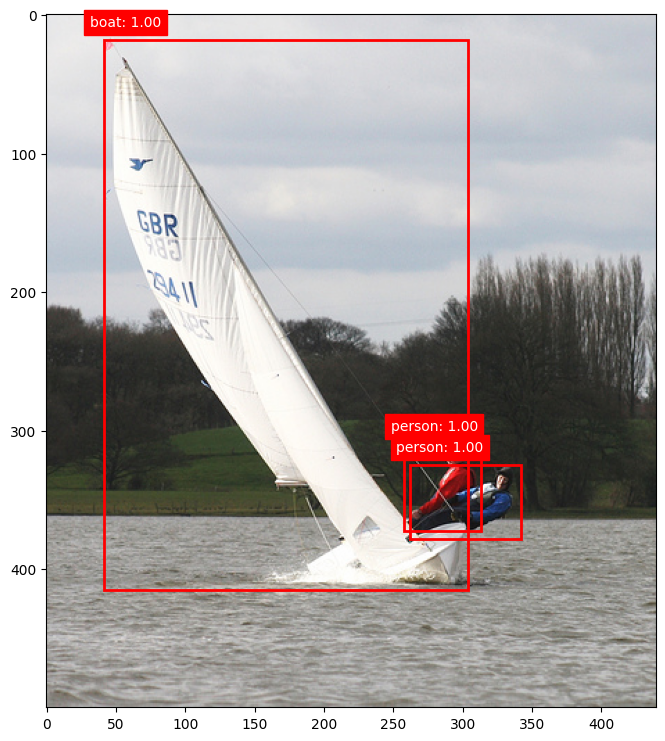

In [19]:
plot_images(dataset, 23)

# Implementando YOLO V3

In [129]:
class Trainer():
    def __init__(self, model, train_loader, val_loader, criterion, optimizer, device):
        self.device = device
        self.model = model.to(device)

        self.train_loader = train_loader
        self.val_loader = val_loader
        
        self.criterion = criterion
        self.optimizer = optimizer
        
        self.history = {
            "train_loss": [],
            "val_loss": []
        }

    def train_one_epoch(self):
        self.model.train()
        running_loss = 0.0

        progress_bar = tqdm(self.train_loader, desc="Training")
        for X, y in progress_bar:
            X, y = X.to(self.device), y.to(self.device)

            pred = self.model(X)
            loss = self.criterion(pred, y)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item() * X.size(0)
            
            progress_bar.set_postfix(loss=loss.item())

        epoch_loss = running_loss / len(self.train_loader.dataset)
        return epoch_loss

    def validate_one_epoch(self):
        self.model.eval()
        running_loss = 0.0

        with torch.no_grad():
            progress_bar = tqdm(self.val_loader, desc="Validating")
            for X, y in progress_bar:
                X, y = X.to(self.device), y.to(self.device)

                pred = self.model(X)
                loss = self.criterion(pred, y)

                running_loss += loss.item() * X.size(0)

                progress_bar.set_postfix(loss=loss.item())

        epoch_loss = running_loss / len(self.val_loader.dataset)
        return epoch_loss

    def fit(self, num_epochs):
        for epoch in range(num_epochs):
            train_loss = self.train_one_epoch()
            val_loss = self.validate_one_epoch()

            self.history["train_loss"].append(train_loss)
            self.history["val_loss"].append(val_loss)

        return self.history

In [ ]:
from dataclasses import dataclass, asdict, field
from typing import Literal, Union

@dataclass
class ConvBlockSpec:
    out_channels: int
    kernel_size: int
    stride: int
    padding: int = field(init=False)

    def __post_init__(self):
        self.padding = 1 if self.kernel_size == 3 else 0

@dataclassŕ
class ResidualBlockSpec:
    num_repeats: int
    channels: int

@dataclass
class ScaleBlockSpec:
    from_layer: int = -1

@dataclass
class UpsampleBlockSpec:
    from_layer: int = -1

config = [
    #===DARKNET-53===
    ConvBlockSpec(32, 3, 1),
    ConvBlockSpec(64, 3, 2),
    ResidualBlockSpec(1, 64),
    
    ConvBlockSpec(128, 3, 2),
    ResidualBlockSpec(2, 128),
    
    ConvBlockSpec(256, 3, 2),
    ResidualBlockSpec(8, 256),
    
    ConvBlockSpec(512, 3, 2),
    ResidualBlockSpec(8, 512),

    ConvBlockSpec(1024, 3, 2),
    ResidualBlockSpec(4, 1024),
    #===DARKNET-53===

    ConvBlockSpec(512, 1, 1),
    ConvBlockSpec(1024, 1, 1),
    ScaleBlockSpec(),
    
    ConvBlockSpec(256, 1, 1),
    UpsampleBlockSpec(),
    
    ConvBlockSpec(256, 1, 1),
    ConvBlockSpec(512, 1, 1),
    ScaleBlockSpec(),

    ConvBlockSpec(128, 1, 1),
    UpsampleBlockSpec(),

    ConvBlockSpec(128, 1, 1),
    ConvBlockSpec(256, 1, 1),
    ScaleBlockSpec(),
]

In [131]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, bn_act=True, **kwargs):
        super().__init__()

        use_bias = not bn_act
        layers = []

        layers.append(
            nn.Conv2d(in_channels, out_channels, bias=use_bias, **kwargs)
        )

        if bn_act:
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.1, inplace=True))

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)


class ResidualBlock(nn.Module):
    def __init__(self, channels, use_residuals=True, num_repeats=1):
        super().__init__()

        self.use_residuals = use_residuals
        self.num_repeats = num_repeats

        layers = nn.ModuleList()

        for _ in range(num_repeats):
            layers.append(
                nn.Sequential(
                    CNNBlock(channels, channels//2, kernel_size=1),
                    CNNBlock(channels//2, channels, kernel_size=3, padding=1),
                )
            )

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        for layer in self.block:
            if self.use_residuals:
                #print(x.shape)
                x = x + layer(x)
            else:
                x = layer(x)
        return x


class ScaleBlock(nn.Module):
    def __init__(self, in_channels, num_classes, num_anchors=3):
        super().__init__()

        self.num_classes = num_classes
        self.num_anchors = num_anchors

        self.pred = nn.Sequential(
            CNNBlock(in_channels, 2*in_channels, kernel_size=3, padding=1),
            CNNBlock(
                2*in_channels,
                self.num_anchors *(num_classes+5),
                bn_act=False,
                kernel_size=1
            ),
        )

        # [p, cx, cy, w, h, Ic1, ..., Icn] * num_anchors
        
    def forward(self, x):
        pred = self.pred(x)

        # N, C, W, H
        N, _, S, _ = pred.shape

        pred = pred.reshape(N, self.num_anchors, self.num_classes+5, S, S)
        pred = pred.permute(0, 1, 3, 4, 2)

        return pred


class YOLOv3(nn.Module):
    def __init__(self, config, num_anchors=3, in_channels=3, num_classes=20):
        super().__init__()
        self.config = config
        self.in_channels = 3
        self.num_classes = 20
        self.num_anchors = num_anchors

        self.layers = self.gen_layers()

    def gen_layers(self):
        layers = nn.ModuleList()
        in_channels = self.in_channels

        for layer in self.config:
            if isinstance(layer, ConvBlockSpec):
                layers.append(CNNBlock(in_channels, **asdict(layer)))
                in_channels = layer.out_channels
            elif isinstance(layer, ResidualBlockSpec):
                layers.append(ResidualBlock(**asdict(layer)))
            elif isinstance(layer, ScaleBlockSpec):
                layers += [
                    ResidualBlock(in_channels, use_residuals=False, num_repeats=1),
                    CNNBlock(in_channels, in_channels//2, kernel_size=1),
                    ScaleBlock(in_channels//2, self.num_classes, num_anchors=self.num_anchors)
                ]
                in_channels = in_channels//2
                
            elif isinstance(layer, UpsampleBlockSpec):
                layers.append(nn.Upsample(scale_factor=2))
                in_channels = in_channels*3

        return layers

    def forward(self, x):
        preds = []
        route_connections = []

        #print(self.layers)

        for layer in self.layers:
            # print(isinstance(layer, CNNBlock))
            # print(isinstance(layer, ResidualBlock))
            # print(isinstance(layer, ScaleBlock))
            # print()

            if isinstance(layer, ScaleBlock):
                print("scale")
                preds.append(layer(x))
                continue
            
            x = layer(x)
            
            if isinstance(layer, ResidualBlock) and layer.num_repeats == 8:
                route_connections.append(x)

            if isinstance(layer, nn.Upsample):
                print("concat")
                x = torch.cat([x, route_connections.pop()], dim=1)

        return preds


In [132]:
yolo = YOLOv3(config, num_anchors=2)
x = torch.randn((11, 3, 416, 416))
print(x.dtype)
out = yolo(x)

torch.float32
scale
concat
scale
concat
scale


In [133]:
for output in out:
    print(output.shape)

torch.Size([11, 2, 13, 13, 25])
torch.Size([11, 2, 26, 26, 25])
torch.Size([11, 2, 52, 52, 25])


In [134]:
for i in range(200):
    test = dataset.get_plot_image(i).to(torch.float32)
    try:
        output = yolo(test.unsqueeze(0))
    except:
        print(f"Xabu no shape {test.shape}")
    else:
        print(test.shape, output.shape)

scale
Xabu no shape torch.Size([3, 375, 500])
scale
Xabu no shape torch.Size([3, 375, 500])
scale
Xabu no shape torch.Size([3, 333, 500])
scale
Xabu no shape torch.Size([3, 375, 500])
scale
Xabu no shape torch.Size([3, 333, 500])
scale
Xabu no shape torch.Size([3, 375, 500])
scale
Xabu no shape torch.Size([3, 331, 500])
scale
Xabu no shape torch.Size([3, 375, 500])
scale
Xabu no shape torch.Size([3, 375, 500])
scale
Xabu no shape torch.Size([3, 369, 500])
scale
Xabu no shape torch.Size([3, 500, 375])
scale
Xabu no shape torch.Size([3, 375, 500])
scale
Xabu no shape torch.Size([3, 500, 375])
scale
Xabu no shape torch.Size([3, 500, 334])
scale
Xabu no shape torch.Size([3, 332, 500])
scale
Xabu no shape torch.Size([3, 375, 500])
scale
Xabu no shape torch.Size([3, 375, 500])
scale
Xabu no shape torch.Size([3, 500, 333])
scale
Xabu no shape torch.Size([3, 333, 500])
scale
Xabu no shape torch.Size([3, 375, 500])
scale
Xabu no shape torch.Size([3, 500, 375])
scale
Xabu no shape torch.Size([3,

In [ ]:
counter = 0

for img in out[1]:
    print(img.shape)
    counter += 1

print(counter)
    #print(out[i].shape)

torch.Size([2, 26, 26, 25])
torch.Size([2, 26, 26, 25])
torch.Size([2, 26, 26, 25])
torch.Size([2, 26, 26, 25])
torch.Size([2, 26, 26, 25])
torch.Size([2, 26, 26, 25])
torch.Size([2, 26, 26, 25])
torch.Size([2, 26, 26, 25])
torch.Size([2, 26, 26, 25])
torch.Size([2, 26, 26, 25])
10


In [55]:
len(out[1][0,0,0,0,:])

25

In [ ]:
res = ResidualBlock(channels=32)
x = torch.randn((2, 32, 416, 416))
res(x).shape

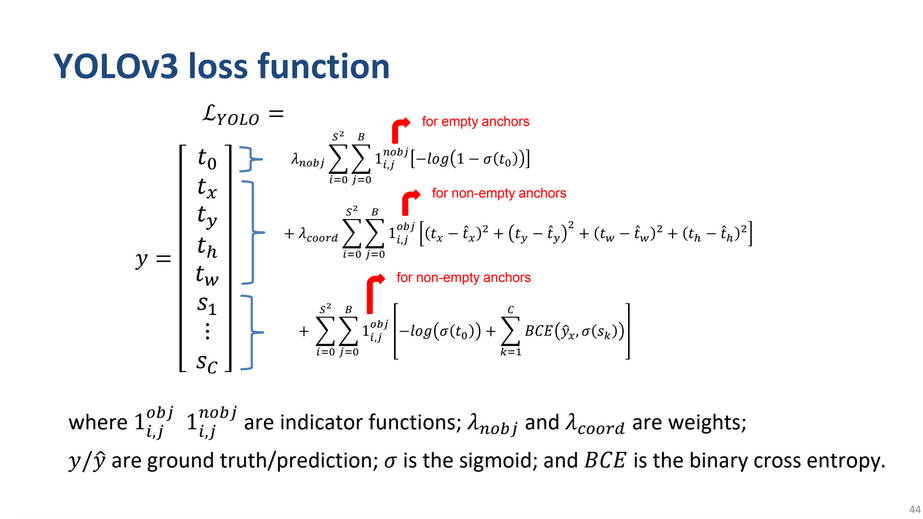

In [270]:
class YOLOv3Loss(nn.Module):
    # (N, B, (tx,ty,tw,th,t0), S, S)

    # pred, true tensor
    # (N, B, S, S, 5+C)
    # N: batch size
    # B: n anchors
    # SxS: grid size
    # 5+C [p0, x, y, w, h, p1,...,pc]

    def __init__(self):
        super().__init__()
        self.sigmoid = nn.Sigmoid()
        self.bce = nn.BCEWithLogitsLoss()
        self.mse = nn.MSELoss()

        self.lambda_noobj = 1
        self.lambda_coord = 1

        self.lambda_class = 1
        self.lambda_obj = 1


    def compute_noobj_loss(self, pred, true, noobj_mask):
        loss = self.bce(
            pred[..., 0:1][noobj_mask],
            true[..., 0:1][noobj_mask],
        )

        return loss

    def compute_obj_loss(self, pred, true, obj_mask):
        loss = self.bce(
            pred[..., 0:1][obj_mask],
            true[..., 0:1][obj_mask]
        )

        return loss

    def compute_coord_loss(self, pred, true, obj_mask, anchors):
        box_pred = pred[..., 1:5][obj_mask]
        box_true = true[..., 1:5][obj_mask]

        wh_pred = box_pred[..., 2:4]
        wh_true = box_true[..., 2:4]

        N, B, S, _ = true.shape[:4]

        anchors_new= anchors.reshape(1, B, 1, 1, 2).expand(N, B, S, S, 2).to(true.device)
        anchor_priors = anchors_new[obj_mask]

        loss_xy = self.mse(
            self.sigmoid(box_pred[..., :2]), box_true[..., :2]
        )

        loss_wh = self.mse(
            wh_pred, torch.log(wh_true/anchor_priors)
        )

        return loss_xy + loss_wh


    def compute_class_loss(self, pred, true, obj_mask):
        obj_pred = pred[obj_mask]
        obj_true = true[obj_mask]

        pred_class = obj_pred[..., 5:]
        true_indices = obj_true[..., 5].long()

        true_class = torch.zeros_like(pred_class)
        true_class.scatter_(1, true_indices.unsqueeze(1), 1)

        loss = self.bce(pred_class, true_class)

        return loss

    def forward(self, pred, true, anchors):
        obj_mask = true[..., 0] == 1
        noobj_mask = ~obj_mask

        obj_loss = self.compute_obj_loss(pred, true, obj_mask)
        noobj_loss = self.compute_noobj_loss(pred, true, noobj_mask)
        coord_loss = self.compute_coord_loss(pred, true, obj_mask, anchors)
        class_loss = self.compute_class_loss(pred, true, obj_mask)

        final_loss = self.lambda_noobj * noobj_loss + \
                     self.lambda_coord * coord_loss + \
                     obj_loss + \
                     class_loss

        return final_loss
